# Master Pipeline Notebook

This notebook orchestrates the entire flood prediction workflow:
1. Data loading & inspection  
2. Leakage diagnostics  
3. Feature engineering  
4. Encoding & scaling  
5. Time-aware & spatial CV  
6. Threshold sweep (baseline)  
7. Resampling & calibration (SMOTE + ensemble)  
8. Threshold tuning  
9. Test-year evaluation  
10. SHAP analysis  
11. Fuzzy logic integration  
12. Forecast wrapper  
13. Final export & sanity checks  


In [1]:
# Imports & setup
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, LeaveOneGroupOut, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
import shap
import joblib
import skfuzzy as fuzz
from skfuzzy import control as ctrl


In [2]:
# 1. Load & inspect data
data_path = Path('../data/cleaned/all_regions.csv')
df = pd.read_csv(data_path, parse_dates=['Date'])

print(df.info())
print('\nClass balance:')
print(df['Flood_Status'].value_counts())

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96448 entries, 0 to 96447
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   96448 non-null  datetime64[ns]
 1   Region                 96448 non-null  object        
 2   Precipitation          96448 non-null  float64       
 3   River_Level            96448 non-null  float64       
 4   Elevation_m            96448 non-null  int64         
 5   Slope_deg              96448 non-null  float64       
 6   Drainage_Density       96448 non-null  float64       
 7   Dist_to_River_km       96448 non-null  float64       
 8   Soil_Type              96448 non-null  object        
 9   Land_Cover             96448 non-null  object        
 10  TWI                    96448 non-null  float64       
 11  NDVI                   96448 non-null  float64       
 12  Precipitation_norm     96448 non-null  float64       
 13  R

,Date,Region,Precipitation,River_Level,Elevation_m,Slope_deg,Drainage_Density,Dist_to_River_km,Soil_Type,Land_Cover,...,TWI_norm,NDVI_norm,risk_score,Flood_Status,Lake_Level,Dam_Level,Elevation_m_norm,Drainage_Density_norm,Lake_Level_norm,Dam_Level_norm
0,2015-01-01,Ak-Suu,0.000000,1.674161,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.080418,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
1,2015-01-02,Ak-Suu,6.378744,2.825170,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.210389,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
2,2015-01-03,Ak-Suu,0.661352,3.003257,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.125043,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
3,2015-01-04,Ak-Suu,3.865727,3.360715,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.184650,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968
4,2015-01-05,Ak-Suu,3.244595,3.141330,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,...,0.616667,1.0,0.169231,0,5.519516,10.752298,0.4,0.214286,0.45648,0.620968


In [3]:
# 2. Leakage diagnostics
features = [c for c in df.columns if '_norm' in c] + ['risk_score']
corrs = df[features + ['Flood_Status']].corr()['Flood_Status'].drop('Flood_Status')
print('Correlations with label:')
print(corrs.sort_values(ascending=False))

# Scatter plots for each proxy feature
# for feat in features:
#     plt.figure(figsize=(6,3))
#     plt.scatter(df[feat], df['Flood_Status'], alpha=0.3)
#     plt.title(f'Scatter: {feat} vs Flood_Status')
#     plt.xlabel(feat); plt.ylabel('Flood_Status')
#     plt.show()

# Drop all raw+normalized proxies (leakage sources)
proxies = features + ['risk_score']
df_model = df.drop(columns=proxies)
print('\nDropped leakage proxies:', proxies)


Correlations with label:
Precipitation_norm       0.559328
risk_score               0.552387
River_Level_norm         0.494380
Lake_Level_norm          0.077156
Dam_Level_norm           0.028371
NDVI_norm                0.007862
Dist_to_River_km_norm    0.005580
TWI_norm                 0.002145
Elevation_m_norm         0.000223
Slope_deg_norm           0.000047
Drainage_Density_norm   -0.005721
Name: Flood_Status, dtype: float64

Dropped leakage proxies: ['Precipitation_norm', 'River_Level_norm', 'Slope_deg_norm', 'Dist_to_River_km_norm', 'TWI_norm', 'NDVI_norm', 'Elevation_m_norm', 'Drainage_Density_norm', 'Lake_Level_norm', 'Dam_Level_norm', 'risk_score', 'risk_score']


In [4]:
# 3. Feature engineering
static_cols = [
    'Elevation_m', 'Slope_deg', 'Drainage_Density', 'Dist_to_River_km',
    'Soil_Type', 'Land_Cover', 'TWI', 'NDVI'
]
df_model = df_model[static_cols + ['Date','Region','Flood_Status']].copy()

# Add cyclical month features
df_model['month']      = df_model['Date'].dt.month
df_model['month_sin']  = np.sin(2 * np.pi * df_model['month'] / 12)
df_model['month_cos']  = np.cos(2 * np.pi * df_model['month'] / 12)
df_model.drop('month', axis=1, inplace=True)

df_model.head()


,Elevation_m,Slope_deg,Drainage_Density,Dist_to_River_km,Soil_Type,Land_Cover,TWI,NDVI,Date,Region,Flood_Status,month_sin,month_cos
0,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-01,Ak-Suu,0,0.5,0.866025
1,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-02,Ak-Suu,0,0.5,0.866025
2,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-03,Ak-Suu,0,0.5,0.866025
3,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-04,Ak-Suu,0,0.5,0.866025
4,1600,8.0,1.4,0.7,sandy_loam,mountain_forest,15.2,0.6,2015-01-05,Ak-Suu,0,0.5,0.866025


In [5]:
# 4. Encode & scale
cat_feats = ['Soil_Type','Land_Cover']
num_feats = [
    c for c in df_model.select_dtypes(include='number').columns
    if c not in ['Flood_Status']
]

preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_feats),
    ('pt' , PowerTransformer(), num_feats)
])

model_pipeline = Pipeline([('preproc', preprocessor)])

# Fit & transform full dataset
X_all = model_pipeline.fit_transform(
    df_model.drop(columns=['Date','Region','Flood_Status'])
)
y_all = df_model['Flood_Status'].values


In [6]:
# 5. Time‑aware & spatial CV splits
df_model['Year'] = df_model['Date'].dt.year

train_mask = df_model['Year'].isin([2015,2016,2017,2018])
val_mask   = df_model['Year'] == 2019
test_mask  = df_model['Year'] == 2020

X_train = df_model.loc[train_mask].drop(
    columns=['Date','Region','Flood_Status','Year']
)
y_train = df_model.loc[train_mask, 'Flood_Status']
groups_train = df_model.loc[train_mask, 'Region']

# TimeSeriesSplit CV
tss = TimeSeriesSplit(n_splits=5)
print('TimeSeriesSplit ROC AUC:',
      cross_val_score(
        LogisticRegression(max_iter=1000),
        model_pipeline.transform(X_train), y_train,
        cv=tss, scoring='roc_auc'
      ))

# Leave-One-Region-Out CV
logo = LeaveOneGroupOut()
print('Leave-One-Region-Out ROC AUC:',
      cross_val_score(
        LogisticRegression(max_iter=1000),
        model_pipeline.transform(X_train), y_train,
        cv=logo.split(X_train, y_train, groups_train),
        scoring='roc_auc'
      ))


TimeSeriesSplit ROC AUC: [0.91779935 0.91094433 0.91366524 0.9125773  0.92303731]
Leave-One-Region-Out ROC AUC: [0.89474058 0.89231434 0.89293889 0.92632814 0.92271542 0.93435587
 0.93472317 0.92570171 0.92227529 0.92893858 0.9251327  0.91588223
 0.91102464 0.91190316 0.90627763 0.90225036 0.89795096 0.91393932
 0.93312205 0.89977365 0.92174783 0.89900474 0.92057006 0.9236474
 0.92867286 0.92661487 0.90524443 0.90793768 0.91997959 0.90335388
 0.91275986 0.9266997  0.90473375 0.9049435  0.9023788  0.92571214
 0.92028089 0.9178631  0.9233825  0.91961244 0.92972243 0.91784278
 0.91125566 0.92554764]


In [7]:
# 6. Threshold sweep (baseline LogisticRegression)
clf_base = LogisticRegression(max_iter=1000)
clf_base.fit(model_pipeline.transform(X_train), y_train)

X_val = df_model.loc[val_mask].drop(
    columns=['Date','Region','Flood_Status','Year']
)
y_val = df_model.loc[val_mask, 'Flood_Status']

val_probs = clf_base.predict_proba(
    model_pipeline.transform(X_val)
)[:,1]

for p in [75, 85, 90, 95]:
    thr = np.percentile(val_probs, p)
    preds = (val_probs >= thr).astype(int)
    print(f'Percentile {p} → F1:', f1_score(y_val, preds),
          'ROC AUC:', roc_auc_score(y_val, val_probs))


Percentile 75 → F1: 0.5625324338349766 ROC AUC: 0.9171553624247684
Percentile 85 → F1: 0.5395238095238095 ROC AUC: 0.9171553624247684
Percentile 90 → F1: 0.4050632911392405 ROC AUC: 0.9171553624247684
Percentile 95 → F1: 0.2516504854368932 ROC AUC: 0.9171553624247684


In [8]:
# 7. Resampling & calibration (SMOTE + LGBM in one pipeline + isotonic calibration)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV

# Build a single pipeline: preproc → SMOTE → LGBM
imb_pipeline = ImbPipeline([
    ('preproc', preprocessor),                      # ColumnTransformer
    ('smote' , SMOTE(random_state=42)),             # balance classes
    ('clf'   , LGBMClassifier(
                    random_state=42,
                    force_row_wise=True               # optional: removes the threading suggestion
                ))
])

# 1) Quick cross‐val on training years
tss = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    imb_pipeline, X_train, y_train,
    cv=tss, scoring='roc_auc'
)
print("LGB mean ROC AUC:", scores.mean())

# 2) Fit the pipeline on all train data
imb_pipeline.fit(X_train, y_train)

# 3) Calibrate probabilities using 5‐fold internal CV
calibrator = CalibratedClassifierCV(
    estimator=imb_pipeline,
    method='isotonic',
    cv=5
)
calibrator.fit(X_train, y_train)

print("✅ Resampling + calibration complete.")


[LightGBM] [Info] Number of positive: 9589, number of negative: 9589
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 19178, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 19255, number of negative: 19255
[LightGBM] [Info] Total Bins 180
[LightGBM] [Info] Number of data points in the train set: 38510, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 28855, number of negative: 28855
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 57710, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 38466, number of negative: 38466
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 76932, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 47972, number of negative: 47972
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 95944, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGB mean ROC AUC: 0.9194409270082378
[LightGBM] [Info] Number of positive: 57625, number of negative: 57625
[LightGBM] [Info] Total Bins 674
[LightGBM] [Info] Number of data points in the train set: 115250, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Resampling + calibration complete.


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [9]:
# 8. Threshold tuning on 2019 validation set
X_val_raw = df_model.loc[val_mask].drop(
    columns=['Date','Region','Flood_Status','Year']
)
y_val = df_model.loc[val_mask, 'Flood_Status']

# Get calibrated probabilities directly (no manual transform)
cal_probs = calibrator.predict_proba(X_val_raw)[:, 1]

# Sweep precision‐recall for F1
prec, recall, threshs = precision_recall_curve(y_val, cal_probs)
f1_scores = 2 * (prec * recall) / (prec + recall + 1e-6)
best_idx  = np.argmax(f1_scores)
best_thr  = threshs[best_idx]

print(f"Best F1 threshold: {best_thr:.4f}   F1 score: {f1_scores[best_idx]:.4f}")

Best F1 threshold: 0.2520   F1 score: 0.5873


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LG

In [10]:
# 9. Test-year evaluation on 2020
X_test_raw = df_model.loc[test_mask].drop(
    columns=['Date','Region','Flood_Status','Year']
)
y_test = df_model.loc[test_mask, 'Flood_Status']

# Predict using calibrated pipeline
test_probs = calibrator.predict_proba(X_test_raw)[:, 1]
test_preds = (test_probs >= best_thr).astype(int)

# Metrics
print("Test ROC AUC:", roc_auc_score(y_test, test_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_preds))

# Per-region & per-month breakdown
df_test = df_model.loc[test_mask].copy()
df_test['prob'], df_test['pred'] = test_probs, test_preds

print("\nPer-region metrics:")
print(df_test.groupby('Region').apply(lambda g: pd.Series({
    'roc_auc': roc_auc_score(g['Flood_Status'], g['prob']),
    'f1'     : f1_score(g['Flood_Status'], g['pred'])
})))

print("\nPer-month metrics:")
print(df_test.groupby(df_test['Date'].dt.month).apply(lambda g: pd.Series({
    'roc_auc': roc_auc_score(g['Flood_Status'], g['prob']),
    'f1'     : f1_score(g['Flood_Status'], g['pred'])
})))


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Test ROC AUC: 0.925081891209857
Confusion Matrix:
 [[12536  1832]
 [  295  1441]]

Per-region metrics:


c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Aelina.Daniiarkyzy\AppData\Local\Temp\ipykernel_8664\1336152801.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_test.groupby('Region').apply(lambda g: p

                roc_auc        f1
Region                           
Ak-Suu         0.895964  0.571429
Ak-Talaa       0.897074  0.615385
Aksy           0.935601  0.647887
Ala-Buka       0.941163  0.686275
Alamudün       0.893058  0.408602
Aravan         0.959284  0.750000
At-Bashy       0.930155  0.602151
Bakay-Ata      0.968521  0.742857
Batken         0.942372  0.610526
Bazar-Korgon   0.940535  0.666667
Bishkek        0.940311  0.519685
Chatkal        0.942688  0.647059
Chüy           0.944022  0.709091
Daroot-Korgon  0.913608  0.571429
Gülchö         0.907247  0.460317
Isfana         0.891234  0.544118
Issyk-Kul      0.901843  0.476190
Jalal-Abad     0.913548  0.418605
Jayil          0.953125  0.637363
Jeti-Ögüz      0.934077  0.588235
Jumgal         0.940857  0.577778
Kadamjay       0.894219  0.583942
Kanysh-Kyya    0.939705  0.661871
Kara-Buura     0.942758  0.602941
Kara-Kulja     0.919163  0.520833
Kara-Suu       0.947277  0.623656
Kemin          0.872433  0.507692
Kochkor       

c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Desktop\flood-prediction\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\Aelina.Daniiarkyzy\OneDrive - University of Central Asia\Deskt

In [11]:
# Additional ML model comparison (loop over RF, XGB, LGB printing ROC AUCs)
import logging

# set LightGBM logger to WARNING or higher
logging.getLogger('lightgbm').setLevel(logging.WARNING)

#  XGBoost “use_label_encoder” warnings:
import warnings
warnings.filterwarnings('ignore', message='.*use_label_encoder.*')

# Silence the “invalid feature names” warning
warnings.filterwarnings(
    'ignore',
    message='.*valid feature names.*'
)



from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

for name, base_clf in [
    ('RF',  RandomForestClassifier(n_estimators=100, random_state=42)),
    ('XGB', XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42)),
    ('LGB', LGBMClassifier(random_state=42, force_row_wise=True))
]:
    # build pipeline
    pipe = ImbPipeline([
        ('preproc', preprocessor),
        ('smote'  , SMOTE(random_state=42)),
        ('clf'    , base_clf)
    ])
    # calibrate
    cal = CalibratedClassifierCV(estimator=pipe, method='isotonic', cv=5)
    cal.fit(X_train, y_train)
    # evaluate on test
    probs = cal.predict_proba(X_test_raw)[:,1]
    print(f"{name} ROC AUC: {roc_auc_score(y_test, probs):.3f}")


RF ROC AUC: 0.925
XGB ROC AUC: 0.925
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of dat

In [13]:
# 10. Model evaluation & comparison on 2020 test set (incl. RF, XGB, LGB)
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ─── Rebuild fuzzy ControlSystem ─────────────────────────────────────────────
precip = ctrl.Antecedent(np.linspace(0,1,100), 'precip')
runoff = ctrl.Antecedent(np.linspace(0,1,100), 'runoff')
risk   = ctrl.Consequent(np.linspace(0,1,100), 'risk')
precip['low'],  precip['high']  = fuzz.trimf(precip.universe,[0,0,0.5]), fuzz.trimf(precip.universe,[0.5,1,1])
runoff['low'], runoff['high'] = fuzz.trimf(runoff.universe,[0,0,0.5]), fuzz.trimf(runoff.universe,[0.5,1,1])
risk['low'],    risk['high']    = fuzz.trimf(risk.universe,   [0,0,0.5]), fuzz.trimf(risk.universe,   [0.5,1,1])
rule_high = ctrl.Rule(precip['high'] & runoff['high'], risk['high'])
rule_low  = ctrl.Rule(precip['low']  | runoff['low'],  risk['low'])
risk_ctrl = ctrl.ControlSystem([rule_high, rule_low])
risk_sim  = ctrl.ControlSystemSimulation(risk_ctrl)

# ─── Prepare data ─────────────────────────────────────────────────────────────
test_mask   = df_model['Year'] == 2020
y_test      = df_model.loc[test_mask, 'Flood_Status'].values
X_test_raw  = df_model.loc[test_mask].drop(columns=['Date','Region','Flood_Status','Year'])
test_clean  = df.loc[test_mask].reset_index(drop=True)

# ─── Baseline & existing pipelines ────────────────────────────────────────────
# A) Logistic @ 0.5
log_probs = clf_base.predict_proba(model_pipeline.transform(X_test_raw))[:,1]
log_preds = (log_probs >= 0.5).astype(int)

# B) Calibrated LGBM @ best_thr
cal_probs = calibrator.predict_proba(X_test_raw)[:,1]
cal_preds = (cal_probs >= best_thr).astype(int)

# C) Fuzzy @ 0.5
fuzzy_probs = []
for p, r in zip(test_clean['Precipitation_norm'], test_clean['River_Level_norm']):
    risk_sim.input['precip'] = p
    risk_sim.input['runoff'] = r
    risk_sim.compute()
    fuzzy_probs.append(risk_sim.output['risk'])
fuzzy_probs = np.array(fuzzy_probs)
fuzzy_preds = (fuzzy_probs >= 0.5).astype(int)

# D) Hybrid (avg)
hybrid_probs = 0.5 * cal_probs + 0.5 * fuzzy_probs
hybrid_preds = (hybrid_probs >= best_thr).astype(int)

# ─── Additional ML models ────────────────────────────────────────────────────
models = {
    'RF' : RandomForestClassifier(n_estimators=100, random_state=42),
    'XGB': XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42),
    'LGB': LGBMClassifier(random_state=42, force_row_wise=True)
}
calibrators = {}
for name, base_clf in models.items():
    pipe = ImbPipeline([
        ('preproc', preprocessor),
        ('smote'  , SMOTE(random_state=42)),
        ('clf'    , base_clf)
    ])
    cal = CalibratedClassifierCV(estimator=pipe, method='isotonic', cv=5)
    cal.fit(X_train, y_train)
    calibrators[name] = cal

# ─── Build metrics table ─────────────────────────────────────────────────────
probs_dict = {
    'Logistic (0.5)'   : log_probs,
    'Calibrated LGBM'  : cal_probs,
    'Fuzzy (0.5)'      : fuzzy_probs,
    'Hybrid (avg)'     : hybrid_probs
}
preds_dict = {
    'Logistic (0.5)'   : log_preds,
    'Calibrated LGBM'  : cal_preds,
    'Fuzzy (0.5)'      : fuzzy_preds,
    'Hybrid (avg)'     : hybrid_preds
}

# Add RF, XGB, LGB results
for name, cal in calibrators.items():
    probs = cal.predict_proba(X_test_raw)[:,1]
    preds = (probs >= best_thr).astype(int)
    probs_dict[f'Calibrated {name}'] = probs
    preds_dict[f'Calibrated {name}'] = preds

# Compile into DataFrame
results = []
for model_name in probs_dict:
    results.append({
        'Model'   : model_name,
        'ROC AUC' : roc_auc_score(y_test, probs_dict[model_name]),
        'PR AUC'  : average_precision_score(y_test, probs_dict[model_name]),
        'F1 Score': f1_score(y_test, preds_dict[model_name])
    })

pd.DataFrame(results).set_index('Model')


[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 92200, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 46100, number of negative: 46100
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 92200, num

,ROC AUC,PR AUC,F1 Score
Model,,,
Logistic (0.5),0.919050,0.438206,0.208153
Calibrated LGBM,0.925082,0.477673,0.575364
Fuzzy (0.5),0.955306,0.693870,0.657150
Hybrid (avg),0.957936,0.681517,0.598300
Calibrated RF,0.925094,0.480731,0.575298
Calibrated XGB,0.924840,0.480126,0.581818
Calibrated LGB,0.925082,0.477673,0.575364


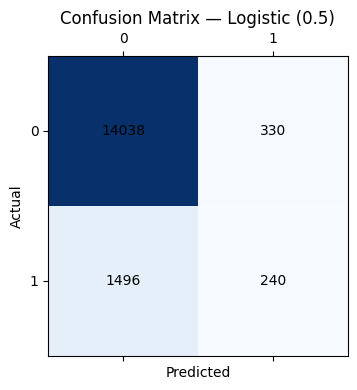

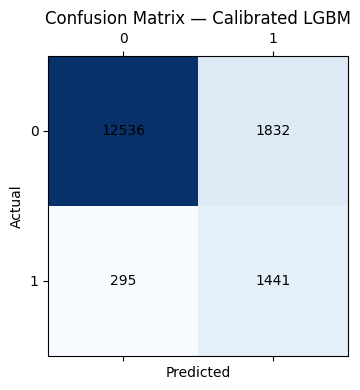

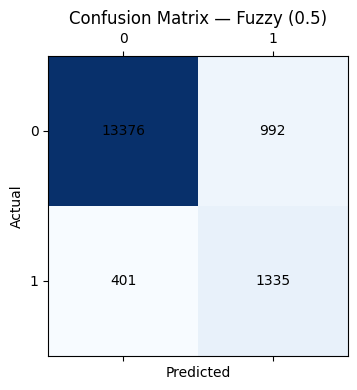

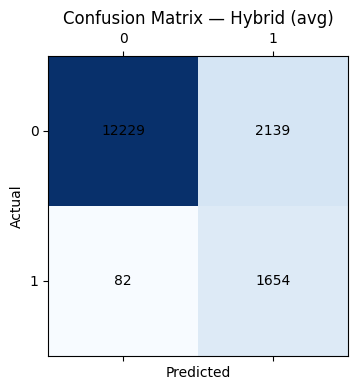

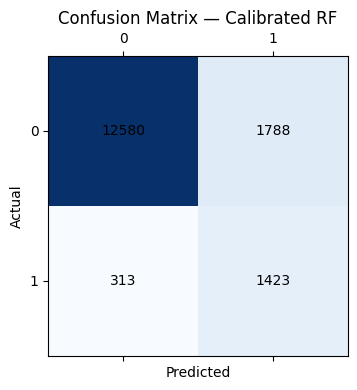

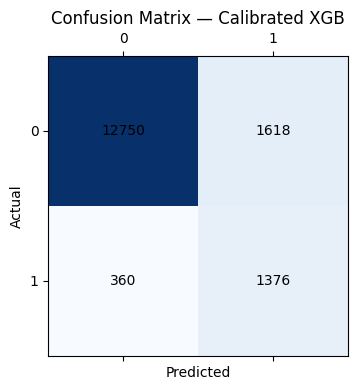

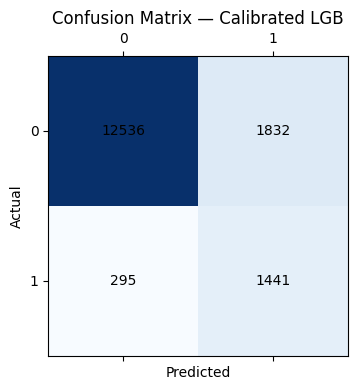

In [ ]:
# from sklearn.metrics import confusion_matrix

# for model_name, preds in preds_dict.items():
#     cm = confusion_matrix(y_test, preds)
#     fig, ax = plt.subplots(figsize=(4,4))
#     cax = ax.matshow(cm, cmap=plt.cm.Blues)
#     for (i,j),val in np.ndenumerate(cm):
#         ax.text(j, i, val, ha='center', va='center')
#     ax.set_xlabel('Predicted')
#     ax.set_ylabel('Actual')
#     ax.set_title(f'Confusion Matrix — {model_name}')
#     plt.tight_layout()
#     plt.show()


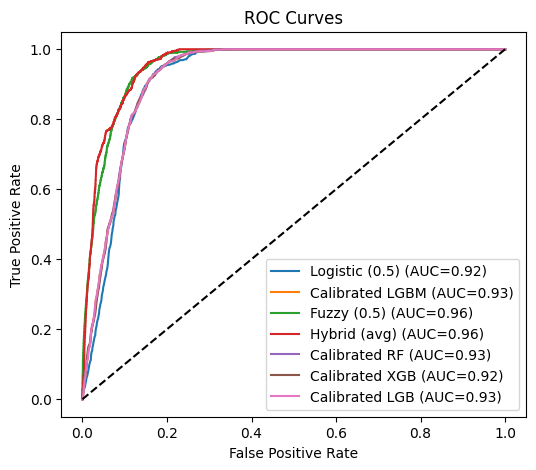

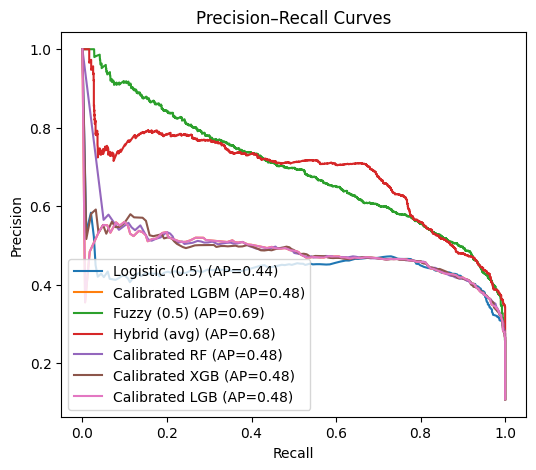

In [ ]:
# from sklearn.metrics import roc_curve, precision_recall_curve

# # a) ROC curves
# plt.figure(figsize=(6,5))
# for name, probs in probs_dict.items():
#     fpr, tpr, _ = roc_curve(y_test, probs)
#     auc  = roc_auc_score(y_test, probs)
#     plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.2f})')
# plt.plot([0,1],[0,1],'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curves')
# plt.legend()
# plt.show()

# # b) Precision–Recall curves
# plt.figure(figsize=(6,5))
# for name, probs in probs_dict.items():
#     prec, rec, _ = precision_recall_curve(y_test, probs)
#     ap = average_precision_score(y_test, probs)
#     plt.plot(rec, prec, label=f'{name} (AP={ap:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision–Recall Curves')
# plt.legend()
# plt.show()


 98%|===================| 15751/16060 [00:37<00:00]        

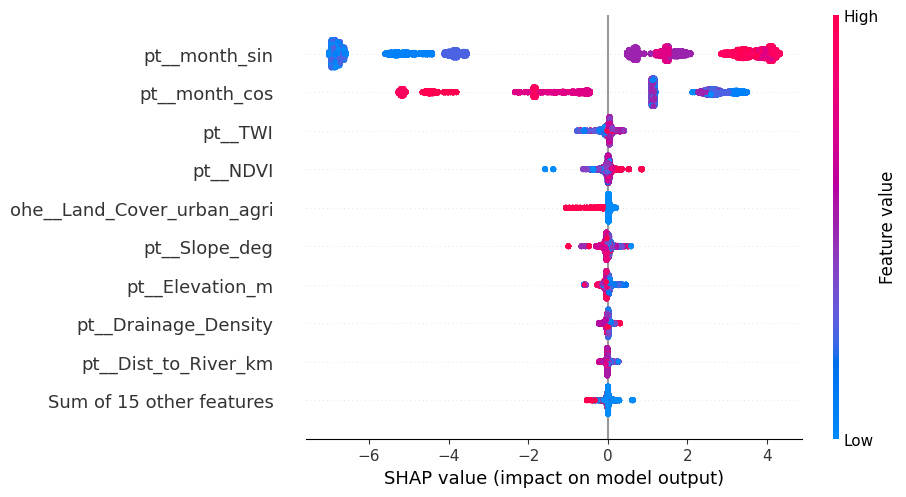

In [ ]:
# # 10. SHAP analysis (beeswarm) with interventional perturbation
# import shap

# # 1) Extract preprocessor and trained LGBM model
# preproc    = calibrator.estimator.named_steps['preproc']
# lgbm_model = calibrator.estimator.named_steps['clf']

# # 2) Transform the 2019 validation set
# X_val_trans = preproc.transform(X_val_raw)

# # 3) Create an Explainer with interventional background
# explainer = shap.Explainer(
#     lgbm_model,
#     X_val_trans,
#     feature_names=preproc.get_feature_names_out(),
#     feature_perturbation="interventional"
# )

# # 4) Compute SHAP values (returns an Explanation object)
# shap_values = explainer(X_val_trans, check_additivity=False)

# # 5) Plot the summary beeswarm directly from the Explanation
# shap.plots.beeswarm(shap_values)

In [17]:
# # 11. Fuzzy logic integration (Mamdani FIS)
# precip = ctrl.Antecedent(np.linspace(0,1,100), 'precip')
# runoff = ctrl.Antecedent(np.linspace(0,1,100), 'runoff')
# risk   = ctrl.Consequent(np.linspace(0,1,100), 'risk')

# # Membership functions
# precip['low']  = fuzz.trimf(precip.universe,  [0,0,0.5])
# precip['high'] = fuzz.trimf(precip.universe,  [0.5,1,1])
# runoff['low']  = fuzz.trimf(runoff.universe,  [0,0,0.5])
# runoff['high'] = fuzz.trimf(runoff.universe,  [0.5,1,1])
# risk['low']    = fuzz.trimf(risk.universe,    [0,0,0.5])
# risk['high']   = fuzz.trimf(risk.universe,    [0.5,1,1])

# # Rules
# rule_high = ctrl.Rule(precip['high'] & runoff['high'], risk['high'])
# rule_low  = ctrl.Rule(precip['low']  | runoff['low'],  risk['low'])

# # Build & simulate
# risk_ctrl = ctrl.ControlSystem([rule_high, rule_low])
# risk_sim  = ctrl.ControlSystemSimulation(risk_ctrl)

# # Visualize
# precip.view()
# runoff.view()
# risk.view()


In [ ]:
# # 12. Forecast wrapper
# def fetch_forecast(api_url):
#     """
#     Placeholder: implement API calls to fetch 3‑day inputs
#     with the same raw columns as training.
#     """
#     return pd.DataFrame()

# def run_pipeline_for_forecast(forecast_df):
#     """
#     Runs ML+Fuzzy on incoming forecast_df (raw features).
#     Returns both ML and fuzzy probabilities.
#     """
#     # ML prediction
#     ml_probs = calibrator.predict_proba(forecast_df)[:, 1]
#     # Fuzzy prediction (requires normalized prec/runoff)
#     risk_sim.input['precip']  = forecast_df['Precipitation_norm'].iloc[0]
#     risk_sim.input['runoff']  = forecast_df['River_Level_norm'].iloc[0]
#     risk_sim.compute()
#     fuzzy_prob = risk_sim.output['risk']
#     return {'ml_probs': ml_probs, 'fuzzy_prob': fuzzy_prob}

# # Example usage:
# # df_fc   = fetch_forecast('YOUR_API_URL')
# # results = run_pipeline_for_forecast(df_fc)


In [ ]:
# # 13. Final export
# os.makedirs('../backend/models', exist_ok=True)

# # Save the entire calibrated pipeline (preproc → SMOTE → LGBM + calibration)
# joblib.dump(calibrator, '../backend/models/calibrated_pipeline.pkl')

# print('✅ Calibrated pipeline saved → ../backend/models/calibrated_pipeline.pkl')
